In [6]:
import os
import pandas as pd

def label_dataset(file_name):
    # Determine the label based on the file name
    if "falling" in file_name or "Falling" in file_name:
        return "falling"
    elif "lying_down" in file_name or "Lying" in file_name:
        return "lying_down"
    elif "sitting" in file_name:
        return "sitting"
    elif "standing" in file_name:
        return "standing"
    elif "walking_fall2" in file_name:
        return "walking"
    else:
        return None

def main(input_directory, output_file):
    all_data = []
    
    # Iterate over all files in the specified directory
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".csv"):
            # Load the dataset
            df = pd.read_csv(os.path.join(input_directory, file_name), header=None, names=["X", "Y", "Z"])
            
            # Label the dataset
            label = label_dataset(file_name)
            if label:
                df["label"] = label
                all_data.append(df)
            else:
                print(f"Warning: {file_name} does not match any predefined categories. Skipping.")
    
    # Combine all labeled datasets
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Save the combined dataset to the output file
    combined_df.to_csv(output_file, index=False)
    print(f"Combined dataset saved to {output_file}")

if __name__ == "__main__":
    # Specify the directory containing your CSV files and the output file name
    input_directory = r"C:\Users\imnit\Downloads\annotationfinal\annotation\standing"
    output_file = "standing_combined_labeled_data.csv"
    
    main(input_directory, output_file)

Combined dataset saved to standing_combined_labeled_data.csv


In [7]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def filter_numeric_rows(df):
    """Keep only rows with numeric values in columns X, Y, Z."""
    return df[pd.to_numeric(df['X'], errors='coerce').notnull()]

def normalize_point_cloud(point_cloud_df):
    """Normalize the XYZ coordinates of a point cloud."""
    xyz = point_cloud_df[['X', 'Y', 'Z']].values
    centroid = xyz.mean(axis=0)
    xyz -= centroid
    furthest_distance = max((xyz**2).sum(axis=1)**0.5)
    xyz /= furthest_distance
    point_cloud_df[['X', 'Y', 'Z']] = xyz
    return point_cloud_df

def main(datasets, output_directory):
    # Load, filter, and normalize datasets
    filtered_dataframes = {category: filter_numeric_rows(pd.read_csv(path, names=['X', 'Y', 'Z', 'label'])) for category, path in datasets.items()}
    for category, df in filtered_dataframes.items():
        df[['X', 'Y', 'Z']] = df[['X', 'Y', 'Z']].astype(float)
        df = normalize_point_cloud(df)
        df.to_csv(os.path.join(output_directory, f'{category}_normalized.csv'), index=False)
    
    # Combine all datasets
    combined_normalized_df = pd.concat(filtered_dataframes.values(), ignore_index=True)
    
    # Split the data
    train_df, temp_df = train_test_split(combined_normalized_df, test_size=0.2, random_state=42, stratify=combined_normalized_df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    # Save the resulting datasets
    train_df.to_csv(os.path.join(output_directory, 'train_data.csv'), index=False)
    val_df.to_csv(os.path.join(output_directory, 'val_data.csv'), index=False)
    test_df.to_csv(os.path.join(output_directory, 'test_data.csv'), index=False)

if __name__ == '__main__':
    # Specify the datasets and the output directory
    datasets = {
        'falling': r'C:\Users\imnit\OneDrive\Desktop\EDA\falling_combined_labeled_data.csv',
        'lying_down': r'C:\Users\imnit\OneDrive\Desktop\EDA\lying_down_combined_labeled_data.csv',
        'sitting': r'C:\Users\imnit\OneDrive\Desktop\EDA\sitting_combined_labeled_data.csv',
        'standing': r'C:\Users\imnit\OneDrive\Desktop\EDA\standing_combined_labeled_data.csv'
    }
    output_directory = r"C:\Users\imnit\OneDrive\Desktop\EDA"
    
    main(datasets, output_directory)

In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load datasets
def load_data(file_path):
    df = pd.read_csv(file_path)
    X = df[['X', 'Y', 'Z']].values
    y = df['label'].values
    return X, y

train_X, train_y = load_data(r"C:\Users\imnit\OneDrive\Desktop\eda\train_data.csv")
val_X, val_y = load_data(r"C:\Users\imnit\OneDrive\Desktop\eda\val_data.csv")
test_X, test_y = load_data(r"C:\Users\imnit\OneDrive\Desktop\eda\test_data.csv")

# Convert labels to integer values
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
val_y = encoder.transform(val_y)
test_y = encoder.transform(test_y)

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),  # Input layer
    tf.keras.layers.Dense(128, activation='relu'),                   # Hidden layer
    tf.keras.layers.Dense(5, activation='softmax')                   # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=64, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_X, test_y)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save(r"C:\Users\imnit\OneDrive\Desktop\EDA\acnn_model")

Epoch 1/64
10762/10762 [==============================] - 17s 2ms/step - loss: 0.7834 - accuracy: 0.6765 - val_loss: 0.7112 - val_accuracy: 0.7022
Epoch 2/64
10762/10762 [==============================] - 16s 2ms/step - loss: 0.6554 - accuracy: 0.7289 - val_loss: 0.6329 - val_accuracy: 0.7349
Epoch 3/64
10762/10762 [==============================] - 16s 2ms/step - loss: 0.6188 - accuracy: 0.7457 - val_loss: 0.6081 - val_accuracy: 0.7468
Epoch 4/64
10762/10762 [==============================] - 17s 2ms/step - loss: 0.5982 - accuracy: 0.7553 - val_loss: 0.5722 - val_accuracy: 0.7648
Epoch 5/64
10762/10762 [==============================] - 21s 2ms/step - loss: 0.5821 - accuracy: 0.7614 - val_loss: 0.5639 - val_accuracy: 0.7683
Epoch 6/64
10762/10762 [==============================] - 22s 2ms/step - loss: 0.5680 - accuracy: 0.7669 - val_loss: 0.5497 - val_accuracy: 0.7749
Epoch 7/64
10762/10762 [==============================] - 22s 2ms/step - loss: 0.5547 - accuracy: 0.7740 - val_loss: 0

INFO:tensorflow:Assets written to: C:\Users\imnit\OneDrive\Desktop\EDA\acnn_model\assets


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Load the data
test_data = pd.read_csv(r"C:\Users\imnit\OneDrive\Desktop\eda\test_data.csv")
test_points = test_data[['X', 'Y', 'Z']].values
test_labels = test_data['label'].values

# Load the trained model
model = tf.keras.models.load_model(r'C:\Users\imnit\OneDrive\Desktop\eda\acnn_model')

# Make predictions
predicted_labels_encoded = np.argmax(model.predict(test_points), axis=1)

# Convert string labels to integer labels for comparison
encoder = LabelEncoder()
true_labels_encoded = encoder.fit_transform(test_labels)

1346/1346 [==============================] - 2s 1ms/step


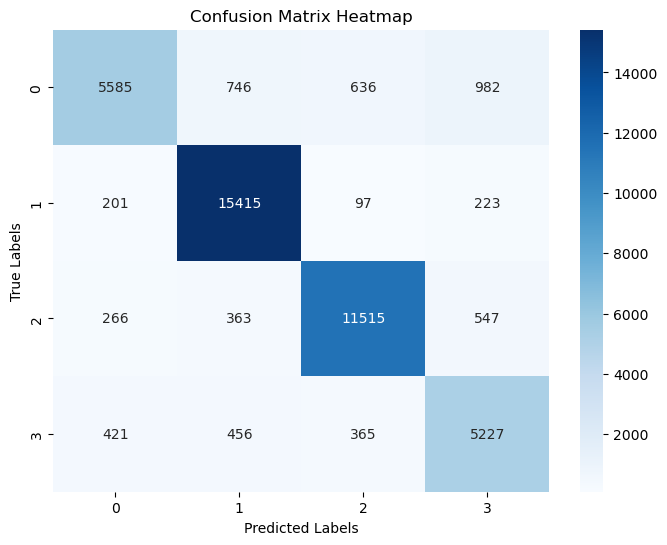

In [14]:
import seaborn as sns

# Create a heatmap of the confusion matrix
conf_matrix = confusion_matrix(true_labels_encoded, predicted_labels_encoded)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


C:\Users\imnit\AppData\Local\Temp\ipykernel_20308\1488549449.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = test_data.corr()


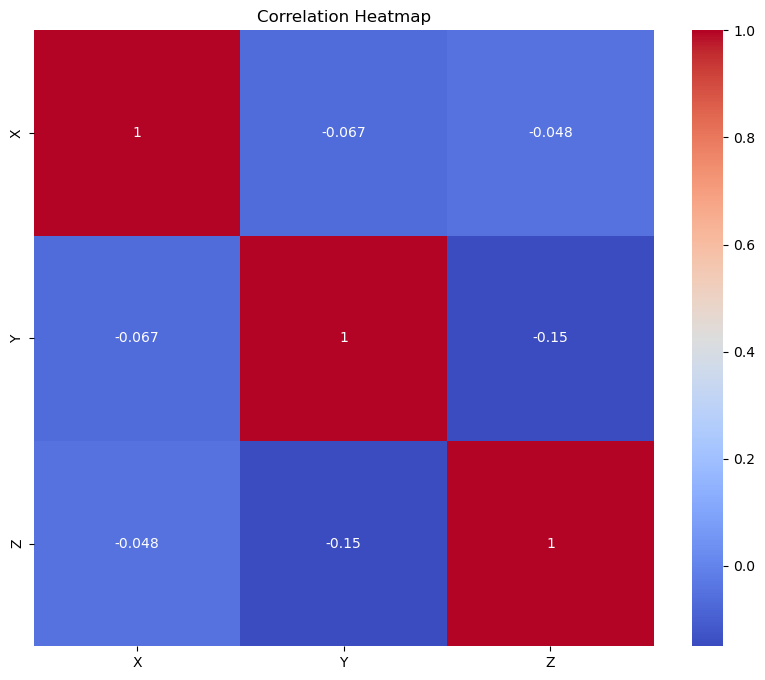

In [15]:
# Calculate the correlation matrix
correlation_matrix = test_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


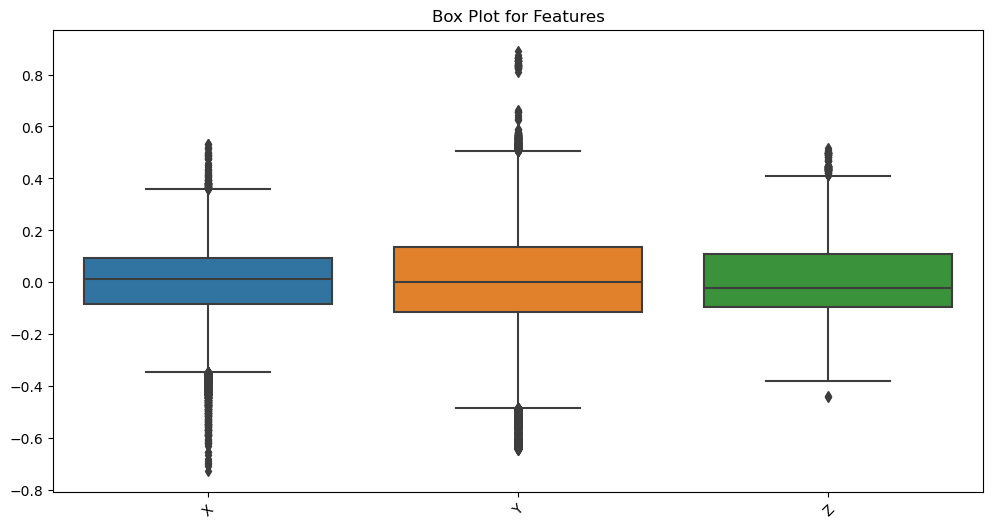

In [16]:
# Create box plots for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=test_data, orient='v')
plt.title('Box Plot for Features')
plt.xticks(rotation=45)
plt.show()


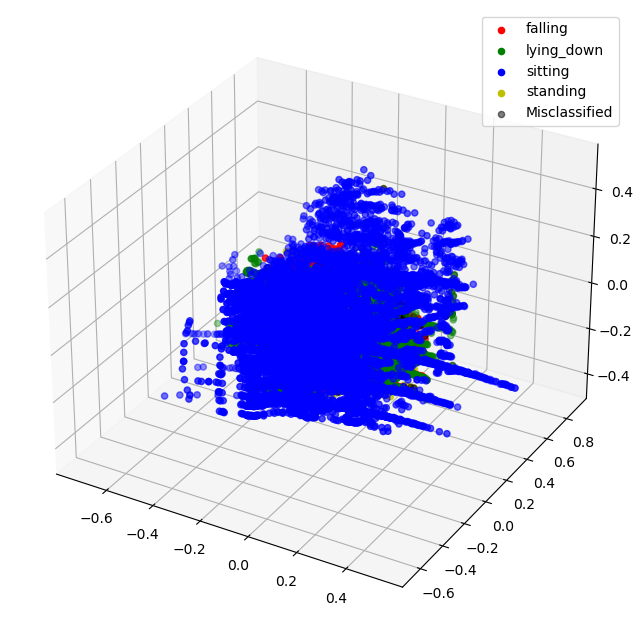

In [19]:
# 3D visualization of test data points
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'y', 'm']
for i, label in enumerate(encoder.classes_):
    subset = test_points[test_labels == label]
    ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], c=colors[i], label=label)

# Highlight misclassified points in black
misclassified = test_points[true_labels_encoded != predicted_labels_encoded]
ax.scatter(misclassified[:, 0], misclassified[:, 1], misclassified[:, 2], c='k', label='Misclassified', alpha=0.5)
ax.legend()
plt.show()